In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import time
import copy
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

import torch 
import os
from torch import nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
from torch import optim
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import torchvision.transforms as transforms
import torchvision

import albumentations as A
from fastprogress import master_bar, progress_bar
from PIL import Image
from albumentations.pytorch import ToTensorV2
import numpy as np
from torch.utils.data import WeightedRandomSampler

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class CheXpertDataset(Dataset):
    def __init__(self, data, root_dir, mode='train', transforms=None):
        self.data = data.to_numpy()
        self.labels = torch.tensor(data.values)
        self.root_dir = root_dir
        self.img_paths = [os.path.join(root_dir, img_path) for img_path in data.index]
        self.transform = transforms.get(mode)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return (image, label)
    
def get_weighted_random_sampler(data):
    weights = 1/data.sum()
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
    return sampler

transforms = {
    'train': A.Compose([
        A.Resize(224, 224),
        A.Affine(scale=(0.9, 1.1), p=0.5),
        A.OneOf([A.Affine(rotate=(-20, 20), p=0.5), A.Affine(shear=(-5, 5), p=0.5)], p=0.5),
        A.Affine(translate_percent=(-0.05, 0.05), p=0.5),
        A.Normalize([0.506, 0.506, 0.506], [0.287, 0.287, 0.287]),
        ToTensorV2()
    ]),
    'val': A.Compose([
        A.Resize(224, 224),
        A.Normalize([0.506, 0.506, 0.506], [0.287, 0.287, 0.287]),
        ToTensorV2()
    ]),
}

In [ ]:
test = pd.read_csv('/kaggle/input/segshag/u1_test.csv',index_col=0)
train = pd.read_csv('/kaggle/input/segshag/u1_train.csv', index_col=0)
val = pd.read_csv('/kaggle/input/segshag/u1_val.csv', index_col=0)

In [ ]:
train.index =  u1_train.index.str.replace('CheXpert-v1.0-small', 'chexpert')
test.index = u1_test.index.str.replace('CheXpert-v1.0-small', 'chexpert')
val.index = u1_val.index.str.replace('CheXpert-v1.0-small', 'chexpert')

In [ ]:
train_dataset = CheXpertDataset(
    data=new_train,
    root_dir='/kaggle/input/', 
    mode='train',
    transforms = transforms
    )
train_loader = DataLoader(
    train_dataset,
    batch_size = 32,
    sampler = get_weighted_random_sampler(new_train),
    num_workers = 4,
    pin_memory=True
    )

/opt/conda/lib/python3.10/site-packages/torch/utils/data/sampler.py:228: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights_tensor = torch.as_tensor(weights, dtype=torch.double)


In [ ]:
pretrained_densenet = models.densenet121(pretrained=True)

for param in pretrained_densenet.features.parameters():
    param.requires_grad = False

# Define a new classifier with additional layers
class CustomDenseNet(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(CustomDenseNet, self).__init__()
        
        # Retain the feature extraction part of the pre-trained DenseNet
        self.features = pretrained_model.features
        
        # Add custom convolutional layers after the DenseNet feature extractor
        self.additional_conv = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),  # Example additional convolutional layer
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Global average pooling (to reduce spatial dimensions before the classifier)
        self.pool = nn.AdaptiveAvgPool2d(1)

        # Final fully connected layer (classifier), adjusted for multi-label classification
        self.classifier = nn.Linear(256, num_classes)  # 128 is the output channels from the conv layers
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # Pass through the DenseNet feature extractor
        x = self.features(x)
        
        # Pass through the additional convolutional layers
        x = self.additional_conv(x)
        
        # Apply global average pooling
        x = self.pool(x)
        
        # Flatten the tensor and pass it through the classifier
        x = torch.flatten(x, 1)  # Flatten the output from the pooling layer
        x = self.classifier(x)
        return x

# Replace the DenseNet's classifier with the custom classifier
num_classes = 14
model = CustomDenseNet(pretrained_densenet, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 153MB/s] 


In [8]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9,0.999), weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                    factor = 0.1, patience = 5, mode = 'max', verbose=True)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
# Wrap the training data loader with tqdm for a progress bar
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
# Forward pass: Get the logits (raw scores) from the model
        outputs = model(inputs)
# Calculate the loss: BCEWithLogitsLoss expects logits, not probabilities
        loss = loss_function(outputs, labels)
# Backward pass and optimization step
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
# Print loss after each epoch
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/500: 100%|██████████| 1/1 [00:01<00:00,  1.73s/batch]


Epoch 1/500, Loss: 0.8867954596572992


Epoch 2/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 2/500, Loss: 0.8239016272887891


Epoch 3/500: 100%|██████████| 1/1 [00:00<00:00,  3.45batch/s]


Epoch 3/500, Loss: 0.7918949162169377


Epoch 4/500: 100%|██████████| 1/1 [00:00<00:00,  3.52batch/s]


Epoch 4/500, Loss: 0.803866578836222


Epoch 5/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 5/500, Loss: 0.8004851813751215


Epoch 6/500: 100%|██████████| 1/1 [00:00<00:00,  3.73batch/s]


Epoch 6/500, Loss: 0.738412288606775


Epoch 7/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 7/500, Loss: 0.7238824513873883


Epoch 8/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 8/500, Loss: 0.7330535425239109


Epoch 9/500: 100%|██████████| 1/1 [00:00<00:00,  2.47batch/s]


Epoch 9/500, Loss: 0.6761017938783601


Epoch 10/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 10/500, Loss: 0.7115543400408457


Epoch 11/500: 100%|██████████| 1/1 [00:00<00:00,  3.79batch/s]


Epoch 11/500, Loss: 0.6741847465034843


Epoch 12/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 12/500, Loss: 0.6780956460907706


Epoch 13/500: 100%|██████████| 1/1 [00:00<00:00,  3.55batch/s]


Epoch 13/500, Loss: 0.6940044450284845


Epoch 14/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 14/500, Loss: 0.7020308742016498


Epoch 15/500: 100%|██████████| 1/1 [00:00<00:00,  3.28batch/s]


Epoch 15/500, Loss: 0.6730511187997936


Epoch 16/500: 100%|██████████| 1/1 [00:00<00:00,  3.30batch/s]


Epoch 16/500, Loss: 0.6705407454655499


Epoch 17/500: 100%|██████████| 1/1 [00:00<00:00,  3.73batch/s]


Epoch 17/500, Loss: 0.6759584868228634


Epoch 18/500: 100%|██████████| 1/1 [00:00<00:00,  3.78batch/s]


Epoch 18/500, Loss: 0.6537572453992795


Epoch 19/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 19/500, Loss: 0.6792638360091737


Epoch 20/500: 100%|██████████| 1/1 [00:00<00:00,  3.48batch/s]


Epoch 20/500, Loss: 0.6764216818536789


Epoch 21/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 21/500, Loss: 0.656300264185355


Epoch 22/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 22/500, Loss: 0.675766527673993


Epoch 23/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 23/500, Loss: 0.6581300746247399


Epoch 24/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 24/500, Loss: 0.6637578872665352


Epoch 25/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 25/500, Loss: 0.6494499001869483


Epoch 26/500: 100%|██████████| 1/1 [00:00<00:00,  2.60batch/s]


Epoch 26/500, Loss: 0.6526901300337855


Epoch 27/500: 100%|██████████| 1/1 [00:00<00:00,  2.68batch/s]


Epoch 27/500, Loss: 0.6623528690935243


Epoch 28/500: 100%|██████████| 1/1 [00:00<00:00,  2.92batch/s]


Epoch 28/500, Loss: 0.641318833093415


Epoch 29/500: 100%|██████████| 1/1 [00:00<00:00,  2.75batch/s]


Epoch 29/500, Loss: 0.6514097562807901


Epoch 30/500: 100%|██████████| 1/1 [00:00<00:00,  2.93batch/s]


Epoch 30/500, Loss: 0.6426277187132106


Epoch 31/500: 100%|██████████| 1/1 [00:00<00:00,  2.91batch/s]


Epoch 31/500, Loss: 0.643873574898417


Epoch 32/500: 100%|██████████| 1/1 [00:00<00:00,  2.81batch/s]


Epoch 32/500, Loss: 0.6529010502626378


Epoch 33/500: 100%|██████████| 1/1 [00:00<00:00,  3.18batch/s]


Epoch 33/500, Loss: 0.6567088399217375


Epoch 34/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 34/500, Loss: 0.6575993939295884


Epoch 35/500: 100%|██████████| 1/1 [00:00<00:00,  3.79batch/s]


Epoch 35/500, Loss: 0.651851318426281


Epoch 36/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 36/500, Loss: 0.6451819481797513


Epoch 37/500: 100%|██████████| 1/1 [00:00<00:00,  3.77batch/s]


Epoch 37/500, Loss: 0.6585133115434407


Epoch 38/500: 100%|██████████| 1/1 [00:00<00:00,  3.77batch/s]


Epoch 38/500, Loss: 0.645119011158744


Epoch 39/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 39/500, Loss: 0.6571607464073584


Epoch 40/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 40/500, Loss: 0.6572907683088682


Epoch 41/500: 100%|██████████| 1/1 [00:00<00:00,  3.78batch/s]


Epoch 41/500, Loss: 0.6795915672664722


Epoch 42/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 42/500, Loss: 0.6440262944644327


Epoch 43/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 43/500, Loss: 0.6562852251186116


Epoch 44/500: 100%|██████████| 1/1 [00:00<00:00,  3.80batch/s]


Epoch 44/500, Loss: 0.6469125351584809


Epoch 45/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 45/500, Loss: 0.64777034259651


Epoch 46/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 46/500, Loss: 0.6542181736971715


Epoch 47/500: 100%|██████████| 1/1 [00:00<00:00,  3.79batch/s]


Epoch 47/500, Loss: 0.6458650026095664


Epoch 48/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 48/500, Loss: 0.6413358417223349


Epoch 49/500: 100%|██████████| 1/1 [00:00<00:00,  3.44batch/s]


Epoch 49/500, Loss: 0.6480488204938766


Epoch 50/500: 100%|██████████| 1/1 [00:00<00:00,  3.73batch/s]


Epoch 50/500, Loss: 0.6510563911276026


Epoch 51/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 51/500, Loss: 0.6433132314307274


Epoch 52/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 52/500, Loss: 0.6663955238285553


Epoch 53/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 53/500, Loss: 0.6461272442270637


Epoch 54/500: 100%|██████████| 1/1 [00:00<00:00,  3.79batch/s]


Epoch 54/500, Loss: 0.637413860343398


Epoch 55/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 55/500, Loss: 0.6414279196350067


Epoch 56/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 56/500, Loss: 0.6511155162316892


Epoch 57/500: 100%|██████████| 1/1 [00:00<00:00,  3.76batch/s]


Epoch 57/500, Loss: 0.6307755203145933


Epoch 58/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 58/500, Loss: 0.6765874787981095


Epoch 59/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 59/500, Loss: 0.6318238736617752


Epoch 60/500: 100%|██████████| 1/1 [00:00<00:00,  3.73batch/s]


Epoch 60/500, Loss: 0.6325623857974222


Epoch 61/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 61/500, Loss: 0.6429036284713591


Epoch 62/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 62/500, Loss: 0.6487113839668759


Epoch 63/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 63/500, Loss: 0.6606351523234979


Epoch 64/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 64/500, Loss: 0.6433645062699803


Epoch 65/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 65/500, Loss: 0.6449252181424315


Epoch 66/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 66/500, Loss: 0.6488829980844782


Epoch 67/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 67/500, Loss: 0.641014929700841


Epoch 68/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 68/500, Loss: 0.645050339833985


Epoch 69/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 69/500, Loss: 0.6649356167556028


Epoch 70/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 70/500, Loss: 0.6786567127497144


Epoch 71/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 71/500, Loss: 0.656787302170803


Epoch 72/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 72/500, Loss: 0.6393727272522564


Epoch 73/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 73/500, Loss: 0.6544322703954831


Epoch 74/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 74/500, Loss: 0.6432252779881356


Epoch 75/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 75/500, Loss: 0.6396222872266362


Epoch 76/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 76/500, Loss: 0.64034376847878


Epoch 77/500: 100%|██████████| 1/1 [00:00<00:00,  3.58batch/s]


Epoch 77/500, Loss: 0.6452149455468118


Epoch 78/500: 100%|██████████| 1/1 [00:00<00:00,  3.81batch/s]


Epoch 78/500, Loss: 0.6433350228752299


Epoch 79/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 79/500, Loss: 0.6625287492572967


Epoch 80/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 80/500, Loss: 0.6429467602898251


Epoch 81/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 81/500, Loss: 0.6695295029131307


Epoch 82/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 82/500, Loss: 0.6447999401261973


Epoch 83/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 83/500, Loss: 0.6468575099608003


Epoch 84/500: 100%|██████████| 1/1 [00:00<00:00,  3.77batch/s]


Epoch 84/500, Loss: 0.6341661365942822


Epoch 85/500: 100%|██████████| 1/1 [00:00<00:00,  3.27batch/s]


Epoch 85/500, Loss: 0.634605536949098


Epoch 86/500: 100%|██████████| 1/1 [00:00<00:00,  3.33batch/s]


Epoch 86/500, Loss: 0.6401555361492041


Epoch 87/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 87/500, Loss: 0.6428095425592089


Epoch 88/500: 100%|██████████| 1/1 [00:00<00:00,  3.77batch/s]


Epoch 88/500, Loss: 0.6524219618449811


Epoch 89/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 89/500, Loss: 0.644787328430959


Epoch 90/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 90/500, Loss: 0.6446424340828079


Epoch 91/500: 100%|██████████| 1/1 [00:00<00:00,  3.82batch/s]


Epoch 91/500, Loss: 0.6296483836180234


Epoch 92/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 92/500, Loss: 0.6509839273890866


Epoch 93/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 93/500, Loss: 0.652975551994756


Epoch 94/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 94/500, Loss: 0.6390785460575943


Epoch 95/500: 100%|██████████| 1/1 [00:00<00:00,  3.78batch/s]


Epoch 95/500, Loss: 0.6350313254281869


Epoch 96/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 96/500, Loss: 0.6352399705661784


Epoch 97/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 97/500, Loss: 0.6332786208757253


Epoch 98/500: 100%|██████████| 1/1 [00:00<00:00,  3.29batch/s]


Epoch 98/500, Loss: 0.6610215319470334


Epoch 99/500: 100%|██████████| 1/1 [00:00<00:00,  3.27batch/s]


Epoch 99/500, Loss: 0.6316433721483216


Epoch 100/500: 100%|██████████| 1/1 [00:00<00:00,  3.29batch/s]


Epoch 100/500, Loss: 0.6703420665719838


Epoch 101/500: 100%|██████████| 1/1 [00:00<00:00,  3.05batch/s]


Epoch 101/500, Loss: 0.6409302026085167


Epoch 102/500: 100%|██████████| 1/1 [00:00<00:00,  3.32batch/s]


Epoch 102/500, Loss: 0.6444012302585469


Epoch 103/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 103/500, Loss: 0.6467232197017388


Epoch 104/500: 100%|██████████| 1/1 [00:00<00:00,  3.48batch/s]


Epoch 104/500, Loss: 0.6423769501092539


Epoch 105/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 105/500, Loss: 0.6483285845976182


Epoch 106/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 106/500, Loss: 0.6346709100890565


Epoch 107/500: 100%|██████████| 1/1 [00:00<00:00,  3.78batch/s]


Epoch 107/500, Loss: 0.6621691299888248


Epoch 108/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 108/500, Loss: 0.6491174993961037


Epoch 109/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 109/500, Loss: 0.6402784718181777


Epoch 110/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 110/500, Loss: 0.646849291275318


Epoch 111/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 111/500, Loss: 0.6646556403923589


Epoch 112/500: 100%|██████████| 1/1 [00:00<00:00,  3.54batch/s]


Epoch 112/500, Loss: 0.6466249954489182


Epoch 113/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 113/500, Loss: 0.6528730408201047


Epoch 114/500: 100%|██████████| 1/1 [00:00<00:00,  2.99batch/s]


Epoch 114/500, Loss: 0.6570135053927301


Epoch 115/500: 100%|██████████| 1/1 [00:00<00:00,  2.92batch/s]


Epoch 115/500, Loss: 0.6469685824546099


Epoch 116/500: 100%|██████████| 1/1 [00:00<00:00,  3.10batch/s]


Epoch 116/500, Loss: 0.6350559267507702


Epoch 117/500: 100%|██████████| 1/1 [00:00<00:00,  3.19batch/s]


Epoch 117/500, Loss: 0.6254745308796774


Epoch 118/500: 100%|██████████| 1/1 [00:00<00:00,  3.06batch/s]


Epoch 118/500, Loss: 0.6307836510459895


Epoch 119/500: 100%|██████████| 1/1 [00:00<00:00,  3.23batch/s]


Epoch 119/500, Loss: 0.6279005991052916


Epoch 120/500: 100%|██████████| 1/1 [00:00<00:00,  3.23batch/s]


Epoch 120/500, Loss: 0.6479300784262981


Epoch 121/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 121/500, Loss: 0.6453540137559373


Epoch 122/500: 100%|██████████| 1/1 [00:00<00:00,  3.78batch/s]


Epoch 122/500, Loss: 0.6355580955922276


Epoch 123/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 123/500, Loss: 0.6380394247989072


Epoch 124/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 124/500, Loss: 0.6524114145464891


Epoch 125/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 125/500, Loss: 0.6557491834079275


Epoch 126/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 126/500, Loss: 0.6454950892245398


Epoch 127/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 127/500, Loss: 0.6505037570632176


Epoch 128/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 128/500, Loss: 0.6313036179541479


Epoch 129/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 129/500, Loss: 0.6337737956766243


Epoch 130/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 130/500, Loss: 0.6402303178343057


Epoch 131/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 131/500, Loss: 0.6511027411807889


Epoch 132/500: 100%|██████████| 1/1 [00:00<00:00,  3.73batch/s]


Epoch 132/500, Loss: 0.6244961996841033


Epoch 133/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 133/500, Loss: 0.6413571391841933


Epoch 134/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 134/500, Loss: 0.6581409951933614


Epoch 135/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 135/500, Loss: 0.6371876572529168


Epoch 136/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 136/500, Loss: 0.6270776390872757


Epoch 137/500: 100%|██████████| 1/1 [00:00<00:00,  2.56batch/s]


Epoch 137/500, Loss: 0.6123412311777469


Epoch 138/500: 100%|██████████| 1/1 [00:00<00:00,  3.57batch/s]


Epoch 138/500, Loss: 0.6339690899136292


Epoch 139/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 139/500, Loss: 0.6575711521994826


Epoch 140/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 140/500, Loss: 0.6258073739603021


Epoch 141/500: 100%|██████████| 1/1 [00:00<00:00,  3.33batch/s]


Epoch 141/500, Loss: 0.6463115022169315


Epoch 142/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 142/500, Loss: 0.6409995425982349


Epoch 143/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 143/500, Loss: 0.639117656134992


Epoch 144/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 144/500, Loss: 0.6534663644576668


Epoch 145/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 145/500, Loss: 0.6370847583311903


Epoch 146/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 146/500, Loss: 0.6274214272770829


Epoch 147/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 147/500, Loss: 0.6333965148456554


Epoch 148/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 148/500, Loss: 0.6405454666920163


Epoch 149/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 149/500, Loss: 0.6429328674483425


Epoch 150/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 150/500, Loss: 0.6302126642315703


Epoch 151/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 151/500, Loss: 0.638595336503906


Epoch 152/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 152/500, Loss: 0.6259514475740687


Epoch 153/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 153/500, Loss: 0.6608663055533226


Epoch 154/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 154/500, Loss: 0.6449828251637312


Epoch 155/500: 100%|██████████| 1/1 [00:00<00:00,  3.05batch/s]


Epoch 155/500, Loss: 0.6408895191100361


Epoch 156/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 156/500, Loss: 0.6311255274712431


Epoch 157/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 157/500, Loss: 0.6408748682876628


Epoch 158/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 158/500, Loss: 0.6351978418527995


Epoch 159/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 159/500, Loss: 0.6289429191087657


Epoch 160/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 160/500, Loss: 0.6293993153741013


Epoch 161/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 161/500, Loss: 0.6295858990852358


Epoch 162/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 162/500, Loss: 0.6254987076648746


Epoch 163/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 163/500, Loss: 0.6312737318257673


Epoch 164/500: 100%|██████████| 1/1 [00:00<00:00,  3.60batch/s]


Epoch 164/500, Loss: 0.62740119212749


Epoch 165/500: 100%|██████████| 1/1 [00:00<00:00,  3.77batch/s]


Epoch 165/500, Loss: 0.6334242997468719


Epoch 166/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 166/500, Loss: 0.6173550310412586


Epoch 167/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 167/500, Loss: 0.6351924196762304


Epoch 168/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 168/500, Loss: 0.6238317673003951


Epoch 169/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 169/500, Loss: 0.6426790237373304


Epoch 170/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 170/500, Loss: 0.647041985130311


Epoch 171/500: 100%|██████████| 1/1 [00:00<00:00,  3.55batch/s]


Epoch 171/500, Loss: 0.6391247679597868


Epoch 172/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 172/500, Loss: 0.6831099062971263


Epoch 173/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 173/500, Loss: 0.6648957406513349


Epoch 174/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 174/500, Loss: 0.6409021266849282


Epoch 175/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 175/500, Loss: 0.637975285329725


Epoch 176/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 176/500, Loss: 0.6413812055783428


Epoch 177/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 177/500, Loss: 0.6505939826915538


Epoch 178/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 178/500, Loss: 0.6468079381561264


Epoch 179/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 179/500, Loss: 0.6392936305197201


Epoch 180/500: 100%|██████████| 1/1 [00:00<00:00,  3.59batch/s]


Epoch 180/500, Loss: 0.638816970851279


Epoch 181/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 181/500, Loss: 0.6526338933662168


Epoch 182/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 182/500, Loss: 0.6443994074426023


Epoch 183/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 183/500, Loss: 0.6466557720722429


Epoch 184/500: 100%|██████████| 1/1 [00:00<00:00,  3.58batch/s]


Epoch 184/500, Loss: 0.6458391085531681


Epoch 185/500: 100%|██████████| 1/1 [00:00<00:00,  3.53batch/s]


Epoch 185/500, Loss: 0.6375821467325192


Epoch 186/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 186/500, Loss: 0.6183428276824068


Epoch 187/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 187/500, Loss: 0.6313321521806141


Epoch 188/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 188/500, Loss: 0.6116757295420914


Epoch 189/500: 100%|██████████| 1/1 [00:00<00:00,  3.42batch/s]


Epoch 189/500, Loss: 0.6507750158879736


Epoch 190/500: 100%|██████████| 1/1 [00:00<00:00,  3.59batch/s]


Epoch 190/500, Loss: 0.6488661491852541


Epoch 191/500: 100%|██████████| 1/1 [00:00<00:00,  3.16batch/s]


Epoch 191/500, Loss: 0.6607843767220734


Epoch 192/500: 100%|██████████| 1/1 [00:00<00:00,  3.50batch/s]


Epoch 192/500, Loss: 0.6256416298637002


Epoch 193/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 193/500, Loss: 0.6311777805412782


Epoch 194/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 194/500, Loss: 0.637415059671189


Epoch 195/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 195/500, Loss: 0.6690108903730789


Epoch 196/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 196/500, Loss: 0.6424215313120027


Epoch 197/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 197/500, Loss: 0.6370499250213439


Epoch 198/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 198/500, Loss: 0.6512612828674588


Epoch 199/500: 100%|██████████| 1/1 [00:00<00:00,  3.39batch/s]


Epoch 199/500, Loss: 0.6391605189934899


Epoch 200/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 200/500, Loss: 0.6370462127883303


Epoch 201/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 201/500, Loss: 0.6614634213987478


Epoch 202/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 202/500, Loss: 0.6311542215737471


Epoch 203/500: 100%|██████████| 1/1 [00:00<00:00,  3.51batch/s]


Epoch 203/500, Loss: 0.6350511425232727


Epoch 204/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 204/500, Loss: 0.6447488072190921


Epoch 205/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 205/500, Loss: 0.6139734630228685


Epoch 206/500: 100%|██████████| 1/1 [00:00<00:00,  3.58batch/s]


Epoch 206/500, Loss: 0.6273722782768344


Epoch 207/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 207/500, Loss: 0.6256372522877682


Epoch 208/500: 100%|██████████| 1/1 [00:00<00:00,  3.45batch/s]


Epoch 208/500, Loss: 0.6546583526459572


Epoch 209/500: 100%|██████████| 1/1 [00:00<00:00,  3.23batch/s]


Epoch 209/500, Loss: 0.6288168921610537


Epoch 210/500: 100%|██████████| 1/1 [00:00<00:00,  3.17batch/s]


Epoch 210/500, Loss: 0.6330749525129215


Epoch 211/500: 100%|██████████| 1/1 [00:00<00:00,  3.13batch/s]


Epoch 211/500, Loss: 0.6180971351800831


Epoch 212/500: 100%|██████████| 1/1 [00:00<00:00,  3.20batch/s]


Epoch 212/500, Loss: 0.6467503920589232


Epoch 213/500: 100%|██████████| 1/1 [00:00<00:00,  3.27batch/s]


Epoch 213/500, Loss: 0.6369575305512245


Epoch 214/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 214/500, Loss: 0.6427809032547013


Epoch 215/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 215/500, Loss: 0.6350892537873458


Epoch 216/500: 100%|██████████| 1/1 [00:00<00:00,  3.54batch/s]


Epoch 216/500, Loss: 0.6215969640976428


Epoch 217/500: 100%|██████████| 1/1 [00:00<00:00,  3.57batch/s]


Epoch 217/500, Loss: 0.6234380116180004


Epoch 218/500: 100%|██████████| 1/1 [00:00<00:00,  3.60batch/s]


Epoch 218/500, Loss: 0.6216221292463907


Epoch 219/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 219/500, Loss: 0.627306886096351


Epoch 220/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 220/500, Loss: 0.6424641110394909


Epoch 221/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 221/500, Loss: 0.6603855065309108


Epoch 222/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 222/500, Loss: 0.6313001259780257


Epoch 223/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 223/500, Loss: 0.65444702141883


Epoch 224/500: 100%|██████████| 1/1 [00:00<00:00,  3.60batch/s]


Epoch 224/500, Loss: 0.6273030177793474


Epoch 225/500: 100%|██████████| 1/1 [00:00<00:00,  3.31batch/s]


Epoch 225/500, Loss: 0.6362210483723345


Epoch 226/500: 100%|██████████| 1/1 [00:00<00:00,  3.25batch/s]


Epoch 226/500, Loss: 0.6544187706220568


Epoch 227/500: 100%|██████████| 1/1 [00:00<00:00,  3.54batch/s]


Epoch 227/500, Loss: 0.6525615538714727


Epoch 228/500: 100%|██████████| 1/1 [00:00<00:00,  3.76batch/s]


Epoch 228/500, Loss: 0.6254302642008411


Epoch 229/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 229/500, Loss: 0.6465245690752253


Epoch 230/500: 100%|██████████| 1/1 [00:00<00:00,  3.53batch/s]


Epoch 230/500, Loss: 0.6314663036625026


Epoch 231/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 231/500, Loss: 0.6408276891526088


Epoch 232/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 232/500, Loss: 0.6227558192737623


Epoch 233/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 233/500, Loss: 0.6448769320091413


Epoch 234/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 234/500, Loss: 0.6163151068515793


Epoch 235/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 235/500, Loss: 0.6447219757995319


Epoch 236/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 236/500, Loss: 0.6269230976489399


Epoch 237/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 237/500, Loss: 0.642774818911971


Epoch 238/500: 100%|██████████| 1/1 [00:00<00:00,  3.55batch/s]


Epoch 238/500, Loss: 0.6447647169551448


Epoch 239/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 239/500, Loss: 0.6257301094012071


Epoch 240/500: 100%|██████████| 1/1 [00:00<00:00,  3.57batch/s]


Epoch 240/500, Loss: 0.6272978683346336


Epoch 241/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 241/500, Loss: 0.6195767667235227


Epoch 242/500: 100%|██████████| 1/1 [00:00<00:00,  3.77batch/s]


Epoch 242/500, Loss: 0.6292057108225791


Epoch 243/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 243/500, Loss: 0.6312460195346659


Epoch 244/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 244/500, Loss: 0.6215594828648471


Epoch 245/500: 100%|██████████| 1/1 [00:00<00:00,  3.53batch/s]


Epoch 245/500, Loss: 0.6214897379374279


Epoch 246/500: 100%|██████████| 1/1 [00:00<00:00,  3.73batch/s]


Epoch 246/500, Loss: 0.6414956105861315


Epoch 247/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 247/500, Loss: 0.6388891936027246


Epoch 248/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 248/500, Loss: 0.6330822530597094


Epoch 249/500: 100%|██████████| 1/1 [00:00<00:00,  3.60batch/s]


Epoch 249/500, Loss: 0.6408471660666348


Epoch 250/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 250/500, Loss: 0.6273070052077777


Epoch 251/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 251/500, Loss: 0.6292062802215628


Epoch 252/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 252/500, Loss: 0.6408566087780363


Epoch 253/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 253/500, Loss: 0.6350353448309297


Epoch 254/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 254/500, Loss: 0.6544649508090369


Epoch 255/500: 100%|██████████| 1/1 [00:00<00:00,  3.54batch/s]


Epoch 255/500, Loss: 0.6330963913087092


Epoch 256/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 256/500, Loss: 0.6427899317159035


Epoch 257/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 257/500, Loss: 0.6292355750476629


Epoch 258/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 258/500, Loss: 0.6195518666652916


Epoch 259/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 259/500, Loss: 0.6234342136595569


Epoch 260/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 260/500, Loss: 0.6593241817784206


Epoch 261/500: 100%|██████████| 1/1 [00:00<00:00,  3.36batch/s]


Epoch 261/500, Loss: 0.6311555406592448


Epoch 262/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 262/500, Loss: 0.650570580611812


Epoch 263/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 263/500, Loss: 0.6408641483395303


Epoch 264/500: 100%|██████████| 1/1 [00:00<00:00,  3.58batch/s]


Epoch 264/500, Loss: 0.6587261347022563


Epoch 265/500: 100%|██████████| 1/1 [00:00<00:00,  3.40batch/s]


Epoch 265/500, Loss: 0.648590866125447


Epoch 266/500: 100%|██████████| 1/1 [00:00<00:00,  3.55batch/s]


Epoch 266/500, Loss: 0.6159159960819464


Epoch 267/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 267/500, Loss: 0.6389080591197723


Epoch 268/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 268/500, Loss: 0.6485768364510142


Epoch 269/500: 100%|██████████| 1/1 [00:00<00:00,  3.60batch/s]


Epoch 269/500, Loss: 0.6429338636862314


Epoch 270/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 270/500, Loss: 0.6646472398602182


Epoch 271/500: 100%|██████████| 1/1 [00:00<00:00,  3.83batch/s]


Epoch 271/500, Loss: 0.6317642401990442


Epoch 272/500: 100%|██████████| 1/1 [00:00<00:00,  3.80batch/s]


Epoch 272/500, Loss: 0.6358940683922898


Epoch 273/500: 100%|██████████| 1/1 [00:00<00:00,  3.78batch/s]


Epoch 273/500, Loss: 0.6427735108768763


Epoch 274/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 274/500, Loss: 0.6486305800787682


Epoch 275/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 275/500, Loss: 0.6447436908194464


Epoch 276/500: 100%|██████████| 1/1 [00:00<00:00,  3.78batch/s]


Epoch 276/500, Loss: 0.630625322799008


Epoch 277/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 277/500, Loss: 0.6258895890196055


Epoch 278/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 278/500, Loss: 0.6434664025362381


Epoch 279/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 279/500, Loss: 0.6499264048321621


Epoch 280/500: 100%|██████████| 1/1 [00:00<00:00,  3.58batch/s]


Epoch 280/500, Loss: 0.6506566189450103


Epoch 281/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 281/500, Loss: 0.6282269760444829


Epoch 282/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 282/500, Loss: 0.6258439426966795


Epoch 283/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 283/500, Loss: 0.6428812099150782


Epoch 284/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 284/500, Loss: 0.6427911839057051


Epoch 285/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 285/500, Loss: 0.6505262005194967


Epoch 286/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 286/500, Loss: 0.6350306441762671


Epoch 287/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 287/500, Loss: 0.6524778333162394


Epoch 288/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 288/500, Loss: 0.6331465389648386


Epoch 289/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 289/500, Loss: 0.6466949689738561


Epoch 290/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 290/500, Loss: 0.638926148066924


Epoch 291/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 291/500, Loss: 0.6314691425068254


Epoch 292/500: 100%|██████████| 1/1 [00:00<00:00,  3.52batch/s]


Epoch 292/500, Loss: 0.6093720189886648


Epoch 293/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 293/500, Loss: 0.6273583063211239


Epoch 294/500: 100%|██████████| 1/1 [00:00<00:00,  3.60batch/s]


Epoch 294/500, Loss: 0.6408351538140176


Epoch 295/500: 100%|██████████| 1/1 [00:00<00:00,  3.57batch/s]


Epoch 295/500, Loss: 0.6277665116044787


Epoch 296/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 296/500, Loss: 0.6350432117449049


Epoch 297/500: 100%|██████████| 1/1 [00:00<00:00,  3.55batch/s]


Epoch 297/500, Loss: 0.6447208470486945


Epoch 298/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 298/500, Loss: 0.6514985045162266


Epoch 299/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 299/500, Loss: 0.6330953204839898


Epoch 300/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 300/500, Loss: 0.6371336210371773


Epoch 301/500: 100%|██████████| 1/1 [00:00<00:00,  3.32batch/s]


Epoch 301/500, Loss: 0.6176955403142192


Epoch 302/500: 100%|██████████| 1/1 [00:00<00:00,  3.34batch/s]


Epoch 302/500, Loss: 0.6447686246747458


Epoch 303/500: 100%|██████████| 1/1 [00:00<00:00,  3.25batch/s]


Epoch 303/500, Loss: 0.6350225958910648


Epoch 304/500: 100%|██████████| 1/1 [00:00<00:00,  3.45batch/s]


Epoch 304/500, Loss: 0.6389071993272064


Epoch 305/500: 100%|██████████| 1/1 [00:00<00:00,  3.37batch/s]


Epoch 305/500, Loss: 0.6372779931042701


Epoch 306/500: 100%|██████████| 1/1 [00:00<00:00,  3.57batch/s]


Epoch 306/500, Loss: 0.6587929655230628


Epoch 307/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 307/500, Loss: 0.6331053968402717


Epoch 308/500: 100%|██████████| 1/1 [00:00<00:00,  3.57batch/s]


Epoch 308/500, Loss: 0.621481191708422


Epoch 309/500: 100%|██████████| 1/1 [00:00<00:00,  3.58batch/s]


Epoch 309/500, Loss: 0.6427792437982999


Epoch 310/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 310/500, Loss: 0.6264677254762862


Epoch 311/500: 100%|██████████| 1/1 [00:00<00:00,  3.76batch/s]


Epoch 311/500, Loss: 0.6503114627496629


Epoch 312/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 312/500, Loss: 0.6292098563003271


Epoch 313/500: 100%|██████████| 1/1 [00:00<00:00,  3.60batch/s]


Epoch 313/500, Loss: 0.6408498553156383


Epoch 314/500: 100%|██████████| 1/1 [00:00<00:00,  3.56batch/s]


Epoch 314/500, Loss: 0.6466951844856081


Epoch 315/500: 100%|██████████| 1/1 [00:00<00:00,  3.59batch/s]


Epoch 315/500, Loss: 0.6315354083523824


Epoch 316/500: 100%|██████████| 1/1 [00:00<00:00,  3.44batch/s]


Epoch 316/500, Loss: 0.6565650226324622


Epoch 317/500: 100%|██████████| 1/1 [00:00<00:00,  3.49batch/s]


Epoch 317/500, Loss: 0.6428002602633579


Epoch 318/500: 100%|██████████| 1/1 [00:00<00:00,  3.36batch/s]


Epoch 318/500, Loss: 0.6345943815481563


Epoch 319/500: 100%|██████████| 1/1 [00:00<00:00,  3.31batch/s]


Epoch 319/500, Loss: 0.6314782454083324


Epoch 320/500: 100%|██████████| 1/1 [00:00<00:00,  3.16batch/s]


Epoch 320/500, Loss: 0.6352869825743707


Epoch 321/500: 100%|██████████| 1/1 [00:00<00:00,  3.07batch/s]


Epoch 321/500, Loss: 0.6466633765103853


Epoch 322/500: 100%|██████████| 1/1 [00:00<00:00,  2.86batch/s]


Epoch 322/500, Loss: 0.6315668700592504


Epoch 323/500: 100%|██████████| 1/1 [00:00<00:00,  3.23batch/s]


Epoch 323/500, Loss: 0.6544205558229709


Epoch 324/500: 100%|██████████| 1/1 [00:00<00:00,  3.38batch/s]


Epoch 324/500, Loss: 0.6333105911021764


Epoch 325/500: 100%|██████████| 1/1 [00:00<00:00,  3.48batch/s]


Epoch 325/500, Loss: 0.6371007234640802


Epoch 326/500: 100%|██████████| 1/1 [00:00<00:00,  3.55batch/s]


Epoch 326/500, Loss: 0.6392155885543648


Epoch 327/500: 100%|██████████| 1/1 [00:00<00:00,  3.36batch/s]


Epoch 327/500, Loss: 0.660365761664195


Epoch 328/500: 100%|██████████| 1/1 [00:00<00:00,  3.35batch/s]


Epoch 328/500, Loss: 0.633188450308947


Epoch 329/500: 100%|██████████| 1/1 [00:00<00:00,  3.29batch/s]


Epoch 329/500, Loss: 0.6234022185226834


Epoch 330/500: 100%|██████████| 1/1 [00:00<00:00,  3.26batch/s]


Epoch 330/500, Loss: 0.6337611784968711


Epoch 331/500: 100%|██████████| 1/1 [00:00<00:00,  3.04batch/s]


Epoch 331/500, Loss: 0.6466623976975084


Epoch 332/500: 100%|██████████| 1/1 [00:00<00:00,  3.34batch/s]


Epoch 332/500, Loss: 0.6331672448285128


Epoch 333/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 333/500, Loss: 0.6470554803883041


Epoch 334/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 334/500, Loss: 0.63889369356435


Epoch 335/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 335/500, Loss: 0.6466735601632615


Epoch 336/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 336/500, Loss: 0.6350142108374826


Epoch 337/500: 100%|██████████| 1/1 [00:00<00:00,  3.58batch/s]


Epoch 337/500, Loss: 0.6408225824122293


Epoch 338/500: 100%|██████████| 1/1 [00:00<00:00,  3.56batch/s]


Epoch 338/500, Loss: 0.6253542977215373


Epoch 339/500: 100%|██████████| 1/1 [00:00<00:00,  3.45batch/s]


Epoch 339/500, Loss: 0.6389586084875395


Epoch 340/500: 100%|██████████| 1/1 [00:00<00:00,  3.40batch/s]


Epoch 340/500, Loss: 0.6428569104347707


Epoch 341/500: 100%|██████████| 1/1 [00:00<00:00,  3.55batch/s]


Epoch 341/500, Loss: 0.6388978772317954


Epoch 342/500: 100%|██████████| 1/1 [00:00<00:00,  3.52batch/s]


Epoch 342/500, Loss: 0.6234084082131061


Epoch 343/500: 100%|██████████| 1/1 [00:00<00:00,  3.59batch/s]


Epoch 343/500, Loss: 0.655545214151811


Epoch 344/500: 100%|██████████| 1/1 [00:00<00:00,  3.57batch/s]


Epoch 344/500, Loss: 0.6157173147719374


Epoch 345/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 345/500, Loss: 0.6609758749640003


Epoch 346/500: 100%|██████████| 1/1 [00:00<00:00,  3.48batch/s]


Epoch 346/500, Loss: 0.64894054664428


Epoch 347/500: 100%|██████████| 1/1 [00:00<00:00,  3.56batch/s]


Epoch 347/500, Loss: 0.6389001143193443


Epoch 348/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 348/500, Loss: 0.6272713822147435


Epoch 349/500: 100%|██████████| 1/1 [00:00<00:00,  3.31batch/s]


Epoch 349/500, Loss: 0.6253455920731673


Epoch 350/500: 100%|██████████| 1/1 [00:00<00:00,  3.42batch/s]


Epoch 350/500, Loss: 0.636989923705607


Epoch 351/500: 100%|██████████| 1/1 [00:00<00:00,  3.40batch/s]


Epoch 351/500, Loss: 0.6194999355570394


Epoch 352/500: 100%|██████████| 1/1 [00:00<00:00,  3.36batch/s]


Epoch 352/500, Loss: 0.6485924157134618


Epoch 353/500: 100%|██████████| 1/1 [00:00<00:00,  3.40batch/s]


Epoch 353/500, Loss: 0.6292356785730818


Epoch 354/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 354/500, Loss: 0.6311622166660265


Epoch 355/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 355/500, Loss: 0.6318478259859736


Epoch 356/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 356/500, Loss: 0.6272788999865525


Epoch 357/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 357/500, Loss: 0.6350655405939469


Epoch 358/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 358/500, Loss: 0.6663071277005065


Epoch 359/500: 100%|██████████| 1/1 [00:00<00:00,  3.80batch/s]


Epoch 359/500, Loss: 0.618021997510853


Epoch 360/500: 100%|██████████| 1/1 [00:00<00:00,  3.59batch/s]


Epoch 360/500, Loss: 0.6276244822276363


Epoch 361/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 361/500, Loss: 0.6408352415694692


Epoch 362/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 362/500, Loss: 0.6408985576730883


Epoch 363/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 363/500, Loss: 0.6388942487937002


Epoch 364/500: 100%|██████████| 1/1 [00:00<00:00,  3.77batch/s]


Epoch 364/500, Loss: 0.6292241978579447


Epoch 365/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 365/500, Loss: 0.635011727932116


Epoch 366/500: 100%|██████████| 1/1 [00:00<00:00,  3.11batch/s]


Epoch 366/500, Loss: 0.648619616027884


Epoch 367/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 367/500, Loss: 0.6292475922475302


Epoch 368/500: 100%|██████████| 1/1 [00:00<00:00,  3.76batch/s]


Epoch 368/500, Loss: 0.633083755615578


Epoch 369/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 369/500, Loss: 0.6350340361385101


Epoch 370/500: 100%|██████████| 1/1 [00:00<00:00,  3.78batch/s]


Epoch 370/500, Loss: 0.6253777806524001


Epoch 371/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 371/500, Loss: 0.6578777707364135


Epoch 372/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 372/500, Loss: 0.6331032457254889


Epoch 373/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 373/500, Loss: 0.6486078561906932


Epoch 374/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 374/500, Loss: 0.6408365547142993


Epoch 375/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 375/500, Loss: 0.618028801370636


Epoch 376/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 376/500, Loss: 0.6351061872795728


Epoch 377/500: 100%|██████████| 1/1 [00:00<00:00,  3.81batch/s]


Epoch 377/500, Loss: 0.6402804835375048


Epoch 378/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 378/500, Loss: 0.6467888737485472


Epoch 379/500: 100%|██████████| 1/1 [00:00<00:00,  3.73batch/s]


Epoch 379/500, Loss: 0.6253401486288584


Epoch 380/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 380/500, Loss: 0.6447199593620583


Epoch 381/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 381/500, Loss: 0.6215019142766286


Epoch 382/500: 100%|██████████| 1/1 [00:00<00:00,  3.60batch/s]


Epoch 382/500, Loss: 0.6234276631706805


Epoch 383/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 383/500, Loss: 0.6467828187796294


Epoch 384/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 384/500, Loss: 0.6253540489746824


Epoch 385/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 385/500, Loss: 0.6311421818243774


Epoch 386/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 386/500, Loss: 0.64082403302959


Epoch 387/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 387/500, Loss: 0.6389273074648507


Epoch 388/500: 100%|██████████| 1/1 [00:00<00:00,  3.79batch/s]


Epoch 388/500, Loss: 0.6408317200634512


Epoch 389/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 389/500, Loss: 0.67816394495169


Epoch 390/500: 100%|██████████| 1/1 [00:00<00:00,  3.54batch/s]


Epoch 390/500, Loss: 0.6311622401326101


Epoch 391/500: 100%|██████████| 1/1 [00:00<00:00,  3.73batch/s]


Epoch 391/500, Loss: 0.6292242277112469


Epoch 392/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 392/500, Loss: 0.6505278157098633


Epoch 393/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 393/500, Loss: 0.6447279247093666


Epoch 394/500: 100%|██████████| 1/1 [00:00<00:00,  3.58batch/s]


Epoch 394/500, Loss: 0.6427875350813467


Epoch 395/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 395/500, Loss: 0.6234956139221995


Epoch 396/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 396/500, Loss: 0.6408310038530323


Epoch 397/500: 100%|██████████| 1/1 [00:00<00:00,  3.46batch/s]


Epoch 397/500, Loss: 0.6466563564154784


Epoch 398/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 398/500, Loss: 0.6330722593990219


Epoch 399/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 399/500, Loss: 0.6259567654483474


Epoch 400/500: 100%|██████████| 1/1 [00:00<00:00,  3.77batch/s]


Epoch 400/500, Loss: 0.6466698240308598


Epoch 401/500: 100%|██████████| 1/1 [00:00<00:00,  3.49batch/s]


Epoch 401/500, Loss: 0.6234857276370296


Epoch 402/500: 100%|██████████| 1/1 [00:00<00:00,  3.22batch/s]


Epoch 402/500, Loss: 0.6544429183296248


Epoch 403/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 403/500, Loss: 0.6388874422778199


Epoch 404/500: 100%|██████████| 1/1 [00:00<00:00,  3.76batch/s]


Epoch 404/500, Loss: 0.6243362950324782


Epoch 405/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 405/500, Loss: 0.6505126904660016


Epoch 406/500: 100%|██████████| 1/1 [00:00<00:00,  3.57batch/s]


Epoch 406/500, Loss: 0.6389267015535427


Epoch 407/500: 100%|██████████| 1/1 [00:00<00:00,  3.49batch/s]


Epoch 407/500, Loss: 0.6370273259462063


Epoch 408/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 408/500, Loss: 0.6369369570230624


Epoch 409/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 409/500, Loss: 0.6234394111206824


Epoch 410/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 410/500, Loss: 0.6466713468569203


Epoch 411/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 411/500, Loss: 0.628692058414987


Epoch 412/500: 100%|██████████| 1/1 [00:00<00:00,  3.73batch/s]


Epoch 412/500, Loss: 0.6350446479379755


Epoch 413/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 413/500, Loss: 0.6428118308758922


Epoch 414/500: 100%|██████████| 1/1 [00:00<00:00,  3.73batch/s]


Epoch 414/500, Loss: 0.6505383044195232


Epoch 415/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 415/500, Loss: 0.6214753613797585


Epoch 416/500: 100%|██████████| 1/1 [00:00<00:00,  3.79batch/s]


Epoch 416/500, Loss: 0.6505961208627943


Epoch 417/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 417/500, Loss: 0.6254054121208603


Epoch 418/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 418/500, Loss: 0.6486244583364313


Epoch 419/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 419/500, Loss: 0.6409015302615084


Epoch 420/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 420/500, Loss: 0.6447485487145437


Epoch 421/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 421/500, Loss: 0.6236033353101132


Epoch 422/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 422/500, Loss: 0.6569127209193432


Epoch 423/500: 100%|██████████| 1/1 [00:00<00:00,  3.77batch/s]


Epoch 423/500, Loss: 0.6176440849244779


Epoch 424/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 424/500, Loss: 0.6431685773380921


Epoch 425/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 425/500, Loss: 0.6525417082017795


Epoch 426/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 426/500, Loss: 0.6369598185122322


Epoch 427/500: 100%|██████████| 1/1 [00:00<00:00,  3.76batch/s]


Epoch 427/500, Loss: 0.6369631292837897


Epoch 428/500: 100%|██████████| 1/1 [00:00<00:00,  3.62batch/s]


Epoch 428/500, Loss: 0.6272952457766567


Epoch 429/500: 100%|██████████| 1/1 [00:00<00:00,  3.78batch/s]


Epoch 429/500, Loss: 0.6408370023202492


Epoch 430/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 430/500, Loss: 0.6427728513720432


Epoch 431/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 431/500, Loss: 0.6311395143777118


Epoch 432/500: 100%|██████████| 1/1 [00:00<00:00,  3.30batch/s]


Epoch 432/500, Loss: 0.6583646406817519


Epoch 433/500: 100%|██████████| 1/1 [00:00<00:00,  3.17batch/s]


Epoch 433/500, Loss: 0.6369656965814753


Epoch 434/500: 100%|██████████| 1/1 [00:00<00:00,  3.27batch/s]


Epoch 434/500, Loss: 0.6388918139725875


Epoch 435/500: 100%|██████████| 1/1 [00:00<00:00,  3.39batch/s]


Epoch 435/500, Loss: 0.6292142270010643


Epoch 436/500: 100%|██████████| 1/1 [00:00<00:00,  3.35batch/s]


Epoch 436/500, Loss: 0.6160412094284777


Epoch 437/500: 100%|██████████| 1/1 [00:00<00:00,  3.39batch/s]


Epoch 437/500, Loss: 0.6253717078555384


Epoch 438/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 438/500, Loss: 0.6564124696710477


Epoch 439/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 439/500, Loss: 0.6427857233194599


Epoch 440/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 440/500, Loss: 0.6388842939608476


Epoch 441/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 441/500, Loss: 0.6466470186341181


Epoch 442/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 442/500, Loss: 0.6215025447767514


Epoch 443/500: 100%|██████████| 1/1 [00:00<00:00,  3.78batch/s]


Epoch 443/500, Loss: 0.6273117428962368


Epoch 444/500: 100%|██████████| 1/1 [00:00<00:00,  3.79batch/s]


Epoch 444/500, Loss: 0.633088216993624


Epoch 445/500: 100%|██████████| 1/1 [00:00<00:00,  3.78batch/s]


Epoch 445/500, Loss: 0.6408505513594551


Epoch 446/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 446/500, Loss: 0.63696359455208


Epoch 447/500: 100%|██████████| 1/1 [00:00<00:00,  3.65batch/s]


Epoch 447/500, Loss: 0.6388980344335572


Epoch 448/500: 100%|██████████| 1/1 [00:00<00:00,  3.70batch/s]


Epoch 448/500, Loss: 0.6120129619536566


Epoch 449/500: 100%|██████████| 1/1 [00:00<00:00,  3.76batch/s]


Epoch 449/500, Loss: 0.6272788190716213


Epoch 450/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 450/500, Loss: 0.6447306276283433


Epoch 451/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 451/500, Loss: 0.6273541175280904


Epoch 452/500: 100%|██████████| 1/1 [00:00<00:00,  3.83batch/s]


Epoch 452/500, Loss: 0.6408278050860453


Epoch 453/500: 100%|██████████| 1/1 [00:00<00:00,  3.78batch/s]


Epoch 453/500, Loss: 0.6214822712991237


Epoch 454/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 454/500, Loss: 0.6118024495555825


Epoch 455/500: 100%|██████████| 1/1 [00:00<00:00,  3.81batch/s]


Epoch 455/500, Loss: 0.6408280775818718


Epoch 456/500: 100%|██████████| 1/1 [00:00<00:00,  3.79batch/s]


Epoch 456/500, Loss: 0.6388988121726826


Epoch 457/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 457/500, Loss: 0.6311446695055788


Epoch 458/500: 100%|██████████| 1/1 [00:00<00:00,  3.59batch/s]


Epoch 458/500, Loss: 0.6525327756354135


Epoch 459/500: 100%|██████████| 1/1 [00:00<00:00,  3.77batch/s]


Epoch 459/500, Loss: 0.6254157387317075


Epoch 460/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 460/500, Loss: 0.627251018127783


Epoch 461/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 461/500, Loss: 0.6486117476779691


Epoch 462/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 462/500, Loss: 0.6388902413943249


Epoch 463/500: 100%|██████████| 1/1 [00:00<00:00,  3.75batch/s]


Epoch 463/500, Loss: 0.6645740426271557


Epoch 464/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 464/500, Loss: 0.6388929481660229


Epoch 465/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 465/500, Loss: 0.6311278901728836


Epoch 466/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 466/500, Loss: 0.6449510294795374


Epoch 467/500: 100%|██████████| 1/1 [00:00<00:00,  3.80batch/s]


Epoch 467/500, Loss: 0.6312542078879685


Epoch 468/500: 100%|██████████| 1/1 [00:00<00:00,  3.74batch/s]


Epoch 468/500, Loss: 0.6408019442573142


Epoch 469/500: 100%|██████████| 1/1 [00:00<00:00,  3.58batch/s]


Epoch 469/500, Loss: 0.6292292643278384


Epoch 470/500: 100%|██████████| 1/1 [00:00<00:00,  3.73batch/s]


Epoch 470/500, Loss: 0.6311368118726253


Epoch 471/500: 100%|██████████| 1/1 [00:00<00:00,  3.71batch/s]


Epoch 471/500, Loss: 0.6428322287533919


Epoch 472/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 472/500, Loss: 0.6272591491240989


Epoch 473/500: 100%|██████████| 1/1 [00:00<00:00,  3.54batch/s]


Epoch 473/500, Loss: 0.6427684498136226


Epoch 474/500: 100%|██████████| 1/1 [00:00<00:00,  3.24batch/s]


Epoch 474/500, Loss: 0.6583785550200989


Epoch 475/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 475/500, Loss: 0.6369554472632369


Epoch 476/500: 100%|██████████| 1/1 [00:00<00:00,  3.60batch/s]


Epoch 476/500, Loss: 0.62148570634913


Epoch 477/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 477/500, Loss: 0.6408687506633168


Epoch 478/500: 100%|██████████| 1/1 [00:00<00:00,  3.77batch/s]


Epoch 478/500, Loss: 0.635031881329944


Epoch 479/500: 100%|██████████| 1/1 [00:00<00:00,  3.76batch/s]


Epoch 479/500, Loss: 0.642535057387281


Epoch 480/500: 100%|██████████| 1/1 [00:00<00:00,  3.50batch/s]


Epoch 480/500, Loss: 0.6311647374238429


Epoch 481/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 481/500, Loss: 0.6408226308030265


Epoch 482/500: 100%|██████████| 1/1 [00:00<00:00,  3.73batch/s]


Epoch 482/500, Loss: 0.6311333326652594


Epoch 483/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 483/500, Loss: 0.6389438976444773


Epoch 484/500: 100%|██████████| 1/1 [00:00<00:00,  3.57batch/s]


Epoch 484/500, Loss: 0.6427395549554076


Epoch 485/500: 100%|██████████| 1/1 [00:00<00:00,  3.68batch/s]


Epoch 485/500, Loss: 0.6350250447514985


Epoch 486/500: 100%|██████████| 1/1 [00:00<00:00,  3.59batch/s]


Epoch 486/500, Loss: 0.6229167472782008


Epoch 487/500: 100%|██████████| 1/1 [00:00<00:00,  3.69batch/s]


Epoch 487/500, Loss: 0.6486200031396706


Epoch 488/500: 100%|██████████| 1/1 [00:00<00:00,  3.67batch/s]


Epoch 488/500, Loss: 0.6330546935323604


Epoch 489/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 489/500, Loss: 0.6505238602415055


Epoch 490/500: 100%|██████████| 1/1 [00:00<00:00,  3.60batch/s]


Epoch 490/500, Loss: 0.646683245934349


Epoch 491/500: 100%|██████████| 1/1 [00:00<00:00,  3.59batch/s]


Epoch 491/500, Loss: 0.6175945007614991


Epoch 492/500: 100%|██████████| 1/1 [00:00<00:00,  3.61batch/s]


Epoch 492/500, Loss: 0.6427533381910451


Epoch 493/500: 100%|██████████| 1/1 [00:00<00:00,  3.63batch/s]


Epoch 493/500, Loss: 0.637007216448797


Epoch 494/500: 100%|██████████| 1/1 [00:00<00:00,  3.56batch/s]


Epoch 494/500, Loss: 0.6311550211534257


Epoch 495/500: 100%|██████████| 1/1 [00:00<00:00,  3.72batch/s]


Epoch 495/500, Loss: 0.6253370493690551


Epoch 496/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 496/500, Loss: 0.6589281226436386


Epoch 497/500: 100%|██████████| 1/1 [00:00<00:00,  3.55batch/s]


Epoch 497/500, Loss: 0.6408343115045559


Epoch 498/500: 100%|██████████| 1/1 [00:00<00:00,  3.64batch/s]


Epoch 498/500, Loss: 0.646616679093722


Epoch 499/500: 100%|██████████| 1/1 [00:00<00:00,  3.66batch/s]


Epoch 499/500, Loss: 0.6447039467771013


Epoch 500/500: 100%|██████████| 1/1 [00:00<00:00,  3.53batch/s]

Epoch 500/500, Loss: 0.6409134754733112


In [10]:
test_dataset = CheXpertDataset(new_test, '/kaggle/input/', 
                                mode='val', transforms = transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size = 32,
    num_workers = 4,
    pin_memory=True)

In [11]:
model.eval()

all_labels = []  # To store all the true labels
all_preds = []  # To store all the predicted probabilities

# Evaluate the model on the validation set
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Get the logits from the model
        outputs = model(inputs)

        # Apply sigmoid to the outputs to get probabilities
        outputs = torch.sigmoid(outputs)

        # Collect the true labels and predictions
        all_labels.append(labels.cpu().numpy())  # Convert to numpy and store
        all_preds.append(outputs.cpu().numpy())  # Convert to numpy and store

# Convert the list of arrays into a single numpy array for true labels and predictions
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# Compute AUROC for multi-label classification
auroc_scores = []
for i in range(all_labels.shape[1]):  # Loop through each label
    auroc = roc_auc_score(all_labels[:, i], all_preds[:, i])  # Calculate AUROC for each label
    auroc_scores.append(auroc)

# Calculate the mean AUROC score across all labels
mean_auroc = np.mean(auroc_scores)
print(f'Mean AUROC: {mean_auroc:.4f}')

Testing: 100%|██████████| 598/598 [01:11<00:00,  8.42batch/s]

Mean AUROC: 0.5267


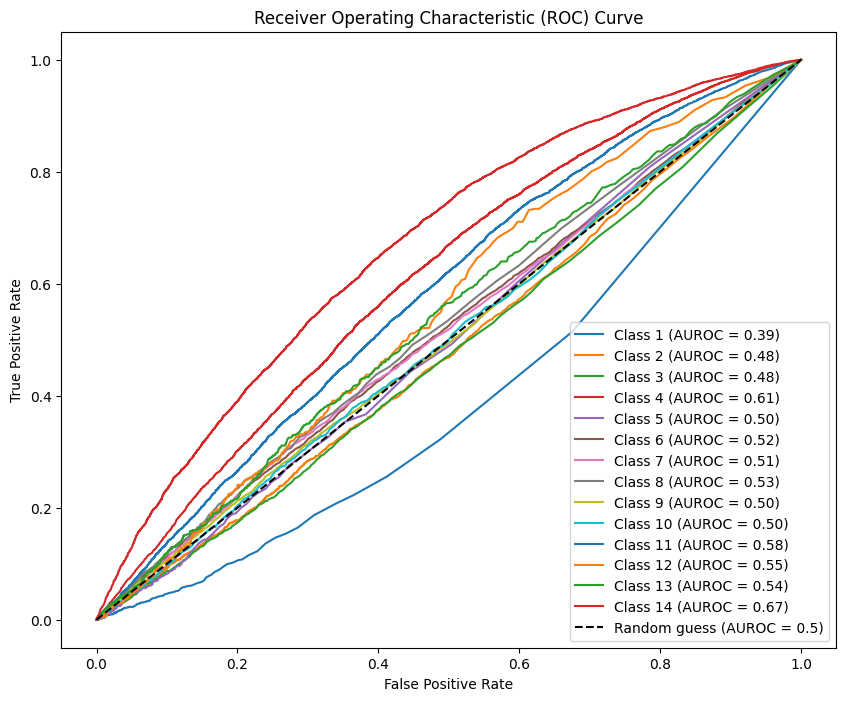

Mean AUROC across all classes: 0.53


0.5267438839838373

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np

# Function to calculate and plot AUROC for multi-label classification
def plot_auroc(model, dataloader, num_classes, device):
    model.eval()
    
    true_labels = []
    predicted_probs = []
    
    # Collect true labels and predicted probabilities
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get raw model output (logits)
            outputs = model(inputs)
            
            # Apply sigmoid to get probabilities for each label
            probs = torch.sigmoid(outputs)
            
            true_labels.append(labels.cpu().numpy())
            predicted_probs.append(probs.cpu().numpy())
    
    # Convert to numpy arrays
    true_labels = np.vstack(true_labels)
    predicted_probs = np.vstack(predicted_probs)

    # Calculate AUROC for each label
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Iterate over each label and compute the ROC curve and AUROC
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc[i] = roc_auc_score(true_labels[:, i], predicted_probs[:, i])

    # Plot the ROC curve for each label
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUROC = {roc_auc[i]:.2f})')
    
    # Plot the diagonal (random guess line)
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess (AUROC = 0.5)')
    
    # Add labels and legend
    plt.title('Multi-label (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    # Return mean AUROC
    mean_auroc = np.mean(list(roc_auc.values()))
    print(f'Mean AUROC across all classes: {mean_auroc:.2f}')
    return mean_auroc

model.to(device)
plot_auroc(model, test_loader, num_classes=14, device='cuda')